# Presentaion of Our Methods
The topic of our project is to design a metric to evaluate teh quality of summaries given the original text. After discussion and paper reading, we think that a good metric for this task should have the following properties:
1. It should be able to tell a good summary from a bad one (The scores of them should be as different as possible).
2. It should be able to discern varying degrees of factual distortion (Given any two summaries according to the same document, the worse one should be scored lower).
3. It should be able to make evaluation based on the detail of the summary (Give the reason why it makes such an evaluation result).

In this notebook, we will present our methods for the project and the results we obtained. The presentation will be divided into following parts, each part will cover the above three properties:
1. Results of baseline metrics
2. Results of our methods
3. Comparison of our methods with baseline metrics
4. Conclusion

In [1]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.plotting.backend = "plotly"
from pipeline import SummaryGrader, NER_comparison, highlight_sent, cos_similariy, Baseline
os.environ['OPENAI_API_KEY'] = 'Your OpenAi API Key'

c:\Users\Alex\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


File Overview:

- Title: falsified_summaries.csv
- Purpose: The dataset we used for our project
- Source: SEC litigation releases
- Date of creation: 2023-11-27
- Last modified: 2023-11-27 


Column Description:

1. pdf_link: The link to the pdf file of the litigation release
2. summary: The summary of the litigation release
3. text_extracted: The text extracted from the pdf file
4. falsified_summary: The summary of the litigation release with factual distortion
5. falsified_index: The index of the sentence in the original text that is distorted

General Formatting Rules:

- Delimiter: ","
- Encoding: UTF-8

In [39]:
df_summary = pd.read_csv('../data/falsified_summary.csv', index_col = 0)
df_summary['good_cos_similarity'] = df_summary['bad_cos_similarity'] = df_summary['good_llm_score'] = df_summary['bad_llm_score'] = np.nan
df_summary['good_llm_mismatch'] = df_summary['bad_llm_mismatch'] = ''
df_summary.head()

,pdf_link,summary,text_extracted,falsified_summary,falsified_index,good_cos_similarity,bad_cos_similarity,good_llm_score,bad_llm_score,good_llm_mismatch,bad_llm_mismatch
0,https://www.sec.gov//litigation/complaints/200...,CORRECTEDThe Securities and Exchange Commissio...,TRACY L. DAVIS (Cal. Bar No. 184129) Attorne...,CORRECTEDThe Securities and Exchange Commissio...,"[2, 5, 6, 8, 9]",NaN,NaN,NaN,NaN,,
1,https://www.sec.gov//litigation/complaints/200...,The United States Securities and Exchange Comm...,"ELECTRONIC \nDEC 29, 2008 \nSTEVEN M, LARIMORE...",The Canadian Securities and Exchange Commissio...,"[0, 1, 2, 4, 5, 6, 8, 12, 13, 18]",NaN,NaN,NaN,NaN,,
2,https://www.sec.gov//litigation/complaints/200...,"The Securities and Exchange Commission (""Commi...",2006 SEP 30 AN 8: 24 \nU.S: COURT MIBDLE GISTR...,"The Securities and Exchange Commission (""Commi...","[1, 2, 5, 6, 8, 9]",NaN,NaN,NaN,NaN,,
3,https://www.sec.gov//litigation/complaints/200...,"The Securities and Exchange Commission (""Commi...",IN THE UNITED STATES DISTRICT COURT FOR THE MI...,"The Securities and Exchange Commission (""Commi...","[0, 1, 4, 7, 8]",NaN,NaN,NaN,NaN,,
4,https://www.sec.gov//litigation/complaints/200...,The Securities and Exchange Commission today f...,08-61524-CIV-DIMITROULEAS/ROSENBAUM \nUNITED S...,The Securities and Exchange Commission today f...,"[0, 1, 3, 4, 6, 7]",NaN,NaN,NaN,NaN,,


File Overview:

- Title: falsified_summary_level.csv
- Purpose: The dataset we used for our project
- Source: SEC litigation releases
- Date of creation: 2023-11-27
- Last modified: 2023-11-27

Column Description:
1. falsified_summary: The summary of the litigation release with factual distortion
2. falsified_index: The index of the sentence in the original text that is distorted
3. text_extracted: The text extracted from the pdf file
   
General Formatting Rules:
- Delimiter: ","
- Encoding: UTF-8

In [38]:
df_summary_level = pd.read_csv('../data/falsified_summary_level.csv', index_col=0)
df_summary_level['cos_similarity'] =  df_summary_level['llm_score'] =  np.nan
df_summary_level['llm_mismatch'] = ''
df_summary_level.head()

,falsified_summary,falsified_index,text_extracted,cos_similarity,llm_score,llm_mismatch
0,The United States Securities and Exchange Comm...,[],"ELECTRONIC \nDEC 29, 2008 \nSTEVEN M, LARIMORE...",NaN,NaN,
1,The United Kingdom Financial Conduct Authority...,"[0, 1, 2, 3, 4]","ELECTRONIC \nDEC 29, 2008 \nSTEVEN M, LARIMORE...",NaN,NaN,
2,The Canadian Securities and Exchange Commissio...,"[0, 1, 2, 4, 5, 6, 8, 12, 13, 18]","ELECTRONIC \nDEC 29, 2008 \nSTEVEN M, LARIMORE...",NaN,NaN,
3,The United States Securities and Exchange Comm...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","ELECTRONIC \nDEC 29, 2008 \nSTEVEN M, LARIMORE...",NaN,NaN,
4,The Canadian Financial Conduct Authority annou...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","ELECTRONIC \nDEC 29, 2008 \nSTEVEN M, LARIMORE...",NaN,NaN,


## 1. Results of baseline metrics
In our analysis, we employ a variety of established metrics to assess the similarity between two text samples. Our baseline approach incorporates four key metrics, each offering a unique perspective on textual similarity:

- **Cosine Similarity**: This metric evaluates the cosine of the angle between two vectors, derived from the text embeddings of the respective documents. A smaller angle signifies greater similarity in the semantic content of the texts.
- **Meteor**: Unlike other metrics that focus solely on lexical similarity, METEOR considers both semantic and syntactic elements, making it highly effective for evaluating translations. It balances precision and recall, and incorporates synonyms and stemming for a more nuanced comparison.
- **Bleu**: Primarily used in machine translation, BLEU assesses the correspondence of n-grams between the translated and reference texts. It prioritizes precision, evaluating the extent to which n-grams in the translated text appear in the reference text.
- **Rouge 2**: This metric focuses on the recall aspect, measuring how many bigrams in the reference summary appear in the generated summary. It's particularly useful for evaluating the extent of content coverage.

For each of these metrics, we calculate the score comparing a well-crafted summary with a deliberately falsified summary, both derived from the same source text.

In [3]:
model = Baseline()
baseline_results = df_summary[['summary', 'falsified_summary']]
baseline_results['cos_similarity'] = baseline_results.apply(lambda x: model.cal_cos_similarity(x['summary'],x['falsified_summary']), axis=1)
baseline_results['meteor'] = baseline_results.apply(lambda x: model.cal_meteor_score(x['summary'],x['falsified_summary']), axis=1)
baseline_results['bleu'] = baseline_results.apply(lambda x: model.cal_bleu_score(x['summary'],x['falsified_summary']), axis=1)
baseline_results['rouge2'] = baseline_results.apply(lambda x: model.cal_rouge2_score(x['summary'],x['falsified_summary']), axis=1)
baseline_results.head()

C:\Users\Alex\AppData\Local\Temp\ipykernel_13372\3942733550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_results['cos_similarity'] = baseline_results.apply(lambda x: model.cal_cos_similarity(x['summary'],x['falsified_summary']), axis=1)
C:\Users\Alex\AppData\Local\Temp\ipykernel_13372\3942733550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_results['meteor'] = baseline_results.apply(lambda x: model.cal_meteor_score(x['summary'],x['falsified_summary']), axis=1)
C:\Users\Alex\Ap

,summary,falsified_summary,cos_similarity,meteor,bleu,rouge2
0,CORRECTEDThe Securities and Exchange Commissio...,CORRECTEDThe Securities and Exchange Commissio...,0.997728,0.958831,0.949553,0.925121
1,The United States Securities and Exchange Comm...,The Canadian Securities and Exchange Commissio...,0.963819,0.972300,0.963332,0.946882
2,"The Securities and Exchange Commission (""Commi...","The Securities and Exchange Commission (""Commi...",0.989780,0.973521,0.965338,0.949947
3,"The Securities and Exchange Commission (""Commi...","The Securities and Exchange Commission (""Commi...",0.999462,0.820663,0.855938,0.802348
4,The Securities and Exchange Commission today f...,The Securities and Exchange Commission today f...,0.995189,0.951790,0.940407,0.906122


**Result:** The analysis yielded notably high scores for all metrics, each exceeding 0.8. This outcome indicates a significant limitation of the baseline metrics: they predominantly failed to detect subtle factual inaccuracies embedded within the summaries.

## 2. Results of our methods
We designed two methods to evaluate the quality of summaries.
1. Named entity comparison
2. Summary grading based on sentence-level checking

### 2.1 Named entity comparison
We provide an `NER_comparison` class with the following methods:
1. `.extract()`: This method can extract the name entities which are related to the financial topic and return them in a `set`.
2. `.process()`: This method can return two ratios, one is the ratio of named entities in the summary that are also in the original text, the other is the ratio of named entities in the original text that are also in the summary. The higher of the two ratios are, the higher the quality of the summary in response to the document is.
3. `.comparison_display()`: This method can highlight the named entities in context. It is designed for visualizing the result of name entity comparison.
4. `.comparison_summary()`: This method will return the ratio of named entities in the summary that are also in the original text, and the set of name entities in the summary but not in the original text.
5. `.comparison_original()`: This This method will return the ratio of named entities in the original text that are also in the summary, and the set of name entities in the original text but not in the summary.

In [4]:
NER_sample = NER_comparison()

# sample a document and its summary
sample_original_text = df_summary.iloc[0,2]
sample_summary = df_summary.iloc[0,1]

# calculate the two ratios
ratio_summary, ratio_original = NER_sample.process(sample_original_text, sample_summary)
print(f"About {round(100*ratio_summary, 2)} % of the name entities in the summary also appear in the original text.")
print(f"About {round(100*ratio_original, 2)} % of the name entities in the original text also appear in the summary.")

About 46.88 % of the name entities in the summary also appear in the original text.
About 12.4 % of the name entities in the original text also appear in the summary.


Highlight the name entities in the summary but not in the original text

In [5]:
# Extract set of entities in the original text
sample_original_ents = NER_sample.extraction(sample_original_text)
# Extract set of entities in the summary
sample_summary_ents = NER_sample.extraction(sample_summary)
# get the set of entities in the summary but not in the original text
_, ents_set = NER_sample.comparison_summary(sample_original_ents, sample_summary_ents)

# highlight the entities in the summary but not in the original text
highlitghted_summary = NER_sample.comparison_display(sample_summary, ents_set)
print(highlitghted_summary)

CORRECTEDThe **Securities and Exchange Commission** **today** charged the former President and CEO of Santa Clara, **Calif.** technology company Genesis Microchip, Inc. with insider trading. The Commission alleges that **Elias Antoun**, who resides in San Jose, bought Genesis stock in the brokerage accounts of a relative and a friend while in the midst of confidential merger negotiations with STMicroelectronics, one of the world's largest semiconductor companies.The **SEC** also charged Antoun's childhood friend, **Samir Abed** of Thousand Oaks, who purchased Genesis stock and options after learning of the merger negotiations from Antoun. Both Antoun and Abed, who netted profits of approximately $33,975 and $**51,206**, respectively, when the merger was announced, agreed to settle the **SEC**'s charges without admitting or denying the Commission's allegations.The Commission's complaint, filed in federal district court in San Jose, alleges that Genesis, a supplier of image processors fo

### 2.2 Summary grading based on sentence-level checking
We apply LLMs to help us check the consistency between the summary and the original text sentence by sentence through `SummaryGrader` class The detail of its structure can be seen in our poster. 
1. Its `.evaluate()` method can return the ratio of sentences in the summary that are thought to be consistent with the original text and the list of indices of sentences in the summary that are thought to be inconsistent with the original text. 
2. In addition, we can use `highlight_sent()` function to highlight the sentences in the summary that are thought to be inconsistent with the original text. This will help users to find the details of the result.

In [ ]:
sg = SummaryGrader()
# Get the LLM Score and the list of indices of sentences in the summary that are thought to be inconsistent with the original text
sample_llm_score, sample_mismatch = sg.evaluate(sample_original_text, sample_summary, 10)
# Highlight the sentences in the summary that are thought to be inconsistent with the original text
highlight_sent(sample_summary, sample_mismatch)

## 3. Comparison of our methods with baseline metrics
In this section, we will compare our methods with the baseline metrics we used in the first section from the three properties we mentioned at the beginning. We will use the same dataset and the same summaries as in the first section. The results are as follows:

### 3.1 Our method performs better in telling a good summary from a bad one.

In [ ]:
# Generate LLM score and cosine similarity
for index, row in df_summary.iterrows():
    text = row['text_extracted']
    summary = row['summary']
    falsi_summary = row['falsified_summary']
    # Generate the cosine similarity for good(standard) and bad(falsified) summary with original text
    row['good_cos_similarity'], row['bad_cos_similarity'] = cos_similariy(text, summary, falsi_summary)
    # Generate the LLM score and the list of indices of sentences in the good summary that are thought to be inconsistent with the original text
    row['good_llm_score'], good_mismatch = sg.evaluate(text, summary, 10)
    # Store the list of indices of sentences as a string
    row['good_llm_mismatch'] = ','.join(str(e) for e in good_mismatch)
    # Generate the LLM score and the list of indices of sentences in the bad summary that are thought to be inconsistent with the original text
    row['bad_llm_score'], bad_mismatch = sg.evaluate(text, falsi_summary, 10)
    # Store the list of indices of sentences as a string
    row['bad_llm_mismatch'] = ','.join(str(e) for e in bad_mismatch)
    df_summary.iloc[index,:] = row

1. `Cosine Similarity Percentage`: The ratio of the difference between Cosine Similarity of good summary and Cosine Similarity of bad summary and Cosine Similarity of good summary.
2. `LLM Score Percentage`: The ratio of the difference between LLM Score of good summary and LLM Score of bad summary and LLM Score of good summary. \
\
Using those two percentages can show the gap between good summary and bad summary

In [ ]:
df_summary['cos_similarity_percentage'] = (df_summary['good_cos_similarity'] - df_summary['bad_cos_similarity'])/df_summary['good_cos_similarity']
df_summary['llm_score_percentage'] = (df_summary['good_llm_score'] - df_summary['bad_llm_score'])/df_summary['good_llm_score']
df_summary.to_csv('10summary_with_result.csv')

### Generate the boxplot for cosine similarity and LLM score

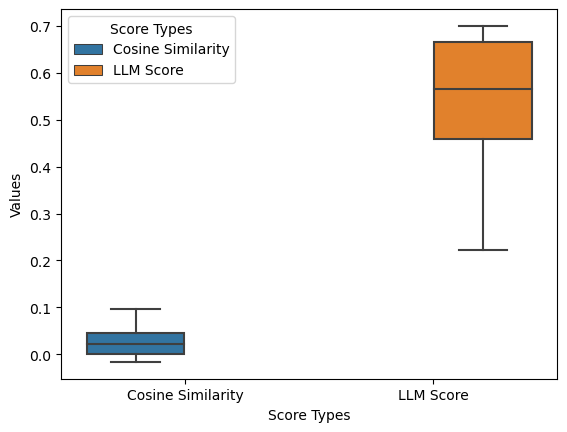

In [6]:
df_summary = pd.read_csv('10summary_with_result.csv', index_col=0)
df_summary = df_summary.rename(columns = {'cos_similarity_percentage': 'Cosine Similarity', 'llm_score_percentage': 'LLM Score'})
df_summary_plot = pd.melt(df_summary.reset_index(), id_vars='index', value_vars=['Cosine Similarity', 'LLM Score'])
df_summary_plot = df_summary_plot.rename(columns = {'variable': 'Score Types'})
sns.boxplot(
    x = 'Score Types', 
    y="value", 
    hue='Score Types', 
    data=df_summary_plot).set(
    xlabel='Score Types', 
    ylabel='Values'
)
plt.savefig('good_to_bad.svg', format="svg", dpi=300)

### 3.2 Our method performs better in discerning varying degrees of factual distortion.

In [ ]:
for index, row in df_summary_level.iterrows():
    text = row['text_extracted']
    falsi_summary = row['falsified_summary']
    # Generate the cosine similarity for summary with original text
    row['cos_similarity'] = cos_similariy(text, falsi_summary, falsi_summary)[0]
    # Generate the LLM score and the list of indices of sentences in the good summary that are thought to be inconsistent with the original text
    row['llm_score'], mismatch = sg.evaluate(text, falsi_summary, 10)
    # Store the list of indices of sentences as a string
    row['llm_mismatch'] = ','.join(str(e) for e in mismatch)

    df_summary_level.iloc[index,:] = row

1. `Falsifed Level`: is defined as the number of sentences with replaced falsified name entities and relationships over the total number of sentences in summary.
2. `Cosine Similarity Percentage`: the ratio of difference between Cosine Similarity of the summary and Cosine Similarity of the previous one and Cosine Similarity of the summary.
3. `LLM Score Percentage`: the ratio of difference between LLM Score of the summary and LLM Score of the previous one(lower falsified level) and LLM Score of the summary.

In [ ]:
# Label the summary with different falsified level
df_summary_level['false_rate'] = np.array([0, 0.25, 0.5, 0.75, 1])
# Generate the Cosine Similarity Percentage summary with different falsifed level
df_summary_level['cos_similarity_percentage'] = (df_summary_level['cos_similarity'].shift(1) - df_summary_level['cos_similarity'])/df_summary_level['cos_similarity'].shift(1)
df_summary_level['llm_percentage'] = (df_summary_level['llm_score'].shift(1) - df_summary_level['llm_score'])/df_summary_level['llm_score'].shift(1)
df_summary_level = df_summary_level.fillna(0)
df_summary_level.to_csv('summary_level_with_result.csv')

### Generate the Lineplot for cosine similarity and LLM score

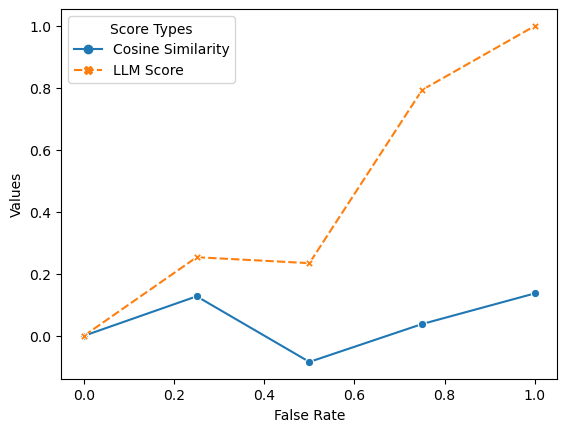

In [19]:
df_summary_level = pd.read_csv('summary_level_with_result.csv', index_col = 0)
df_summary_level = df_summary_level.rename(columns = {
            'cos_similarity_percentage': 'Cosine Similarity', 
            'llm_percentage': 'LLM Score',
            'false_rate': 'False Rate'})
df_summary_level_plot = pd.melt(df_summary_level.reset_index(), id_vars='False Rate', value_vars=['Cosine Similarity', 'LLM Score'])
df_summary_level_plot = df_summary_level_plot.rename(columns = {'variable': 'Score Types'})
df_summary_level_plot
sns.lineplot(
    data=df_summary_level_plot,
    x = 'False Rate', 
    y="value", 
    hue='Score Types', 
    markers=True,
    style='Score Types').set(
    xlabel='False Rate', 
    ylabel='Values'
)
plt.savefig('10levels.svg', format="svg", dpi=300)

### 3.3 Our method is able to make evaluation based on the detail of the summary.
As we described in section 2, both of our method calculate the score of the summary based on the details of it. One is from the name entity level, the other is from the sentence level. However, **the baseline method could only just return a number, which is too abstract for users to understand.** 

Here, we apply `highlight_sent()` function to highlight the sentences in the sampled summary that might be inconsistent with the sampled original text.

In [33]:
sample_summary = df_summary.iloc[0,0]
sample_mismatch_by_llm = [int(e) for e in df_summary.iloc[0,9].split(',')]
# highlight the sentences in the summary that might be inconsistent with the original text. 
highlight_sent(sg._split_text(sample_summary), sample_mismatch_by_llm, 'green')

## 4. Conclusion
In Section 3.1, the plot reveals that when analyzing different PDF files with 50% to 60% summary falsification, particularly where named entities and numbers in the summaries are altered, cosine similarity fails to effectively distinguish between original and falsified summaries. In contrast, our methods demonstrate a clear capacity to discern these differences.

Similarly, Section 3.2's plot underscores this point for the same PDF file subjected to varying levels of summary falsification. Here again, cosine similarity proves inadequate in differentiating between the original and falsified summaries, whereas our methods exhibit a distinct advantage in highlighting these discrepancies.

In Section 3.3, the highlight function could help user to better understand the result of our metric.

Overall, our methods consistently outperform baseline metrics across the three key properties initially outlined. This superior performance strongly suggests that our methods are more effective than the traditional baseline metrics in detecting summary falsification in PDF files.